<a href="https://colab.research.google.com/github/quetion/time_series_SCU/blob/main/TS_Ch4_%E9%A0%90%E6%B8%AC%E8%A1%A8%E7%8F%BE%E4%B9%8B%E8%A9%95%E4%BC%B0_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diebold-Mariano 檢定
- 以比特幣報酬為例
- 比較AR(1)與AR(2)的模型預測能力
- 利用Diebold-Mariano 檢定

In [1]:
# upgrade yfinance
!pip install --upgrade yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [2]:
# package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
#from statsmodels.regression.rolling import RollingOLS

In [3]:
data = yf.download('^gspc',start = '2021-01-01',end='2025-05-01')
data = data[['Close']] # only keep column = ['Close']
data.columns = ['price_spx'] # rename the column
#data.index = pd.to_datetime(data.index) # reset the index to be the date format

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

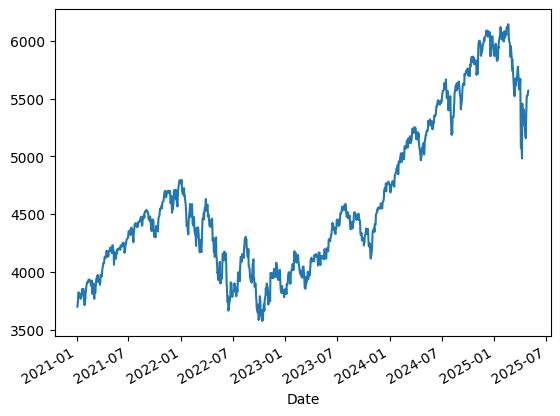

In [4]:
data.price_spx.plot()

## 設定自變數
- 報酬率
- 落後一期報酬率
- 落後二期報酬率

- 這裡是建立報酬率
$$
y_t, y_{t-1}
$$
- markdown語法
`the format code`

In [9]:
# construct the log return (y_t)
data['ret_spx'] = np.log(data.price_spx).diff()
# construct the lagged return (y_{t-1},y_{t-2})
data['ret_spx_1'] = data.ret_spx.shift(1)
data['ret_spx_2'] = data.ret_spx.shift(2)
data['ret_spx_3'] = data.ret_spx.shift(3)
data['ret_spx_4'] = data.ret_spx.shift(4)
data['ret_spx_5'] = data.ret_spx.shift(5)

In [11]:
# construct AR(3) (in-sample)
y = data.ret_spx
x = sm.add_constant(data[['ret_spx_1','ret_spx_2','ret_spx_3','ret_spx_4']])
results = sm.OLS(y,x,missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_spx   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.668
Date:                Thu, 08 May 2025   Prob (F-statistic):              0.155
Time:                        05:23:56   Log-Likelihood:                 3333.9
No. Observations:                1081   AIC:                            -6658.
Df Residuals:                    1076   BIC:                            -6633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.172      0.2

## 設定樣本範圍
- 資料總數為`1081`
- 樣本內資料設定為`R=200`
- 樣本外資料設定為`P=881`


In [12]:
R = 200 # the number in the sample to construct the model
P = len(data) - R # the number (out-of-sample) to check the performance of the model
print(R,P)


200 886


In [14]:
y = data.ret_spx[1:201]
y

,ret_spx
Date,
2021-01-05,0.007058
2021-01-06,0.005694
2021-01-07,0.014738
2021-01-08,0.005477
2021-01-11,-0.006576
...,...
2021-10-13,0.003018
2021-10-14,0.016919
2021-10-15,0.007433


In [16]:
data[['ret_spx_1','ret_spx_2','ret_spx_3']].iloc[1:201]

,ret_spx_1,ret_spx_2,ret_spx_3
Date,,,
2021-01-05,NaN,NaN,NaN
2021-01-06,0.007058,NaN,NaN
2021-01-07,0.005694,0.007058,NaN
2021-01-08,0.014738,0.005694,0.007058
2021-01-11,0.005477,0.014738,0.005694
...,...,...,...
2021-10-13,-0.002420,-0.006889,-0.001916
2021-10-14,0.003018,-0.002420,-0.006889
2021-10-15,0.016919,0.003018,-0.002420


In [18]:
y = data.ret_spx[1:201]
x = sm.add_constant(data[['ret_spx_1','ret_spx_2','ret_spx_3']].iloc[1:201])
result_ar3 = sm.OLS(y,x,missing='drop').fit()

In [20]:
# out-of-sample MSE (mean of squared error)
e1 = np.zeros(P) # AR(3) error
e2 = np.zeros(P) # AR(4) error
for i in range(1,P-1):
    y = data.ret_spx[i:R+i]
    x = sm.add_constant(data[['ret_spx_1','ret_spx_2','ret_spx_3']].iloc[i:R+i])
    result_ar3 = sm.OLS(y,x,missing='drop').fit()
    x = sm.add_constant(data[['ret_spx_1','ret_spx_2','ret_spx_3','ret_spx_4']][i:R+i])
    result_ar4 = sm.OLS(y,x,missing='drop').fit()
    fitted_ar3 = result_ar3.params[0] + result_ar3.params[1]*data.ret_spx_1[R+i] + result_ar3.params[2]*data.ret_spx_2[R+i] + result_ar3.params[3]*data.ret_spx_3[R+i]
    fitted_ar4 = result_ar4.params[0] + result_ar4.params[1]*data.ret_spx_1[R+i] + result_ar4.params[2]*data.ret_spx_2[R+i] + result_ar4.params[3]*data.ret_spx_3[R+i] + result_ar4.params[4]*data.ret_spx_4[R+i]
    e1[i] = data.ret_spx[R+i] - fitted_ar3
    e2[i] = data.ret_spx[R+i] - fitted_ar4
mse_ar3_oos = np.mean(e1**2)
mse_ar4_oos = np.mean(e2**2)
print(mse_ar3_oos)
print(mse_ar4_oos)

Streaming output truncated to the last 5000 lines.
<ipython-input-20-aa3ca0c1699a>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_ar3 = result_ar3.params[0] + result_ar3.params[1]*data.ret_spx_1[R+i] + result_ar3.params[2]*data.ret_spx_2[R+i] + result_ar3.params[3]*data.ret_spx_3[R+i]
<ipython-input-20-aa3ca0c1699a>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_ar4 = result_ar4.params[0] + result_ar4.params[1]*data.ret_spx_1[R+i] + result_ar4.params[2]*data.ret_spx_2[R+i] + result_ar4.params[3]*data.ret_spx_3[R+i] + result_ar4.params[4]*data.ret_spx_4[R+i]
<ipython-input-20-aa3ca0c1699a>:12: Futu

0.0001417202710038156
0.00014369663792649417


<ipython-input-20-aa3ca0c1699a>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_ar3 = result_ar3.params[0] + result_ar3.params[1]*data.ret_spx_1[R+i] + result_ar3.params[2]*data.ret_spx_2[R+i] + result_ar3.params[3]*data.ret_spx_3[R+i]
<ipython-input-20-aa3ca0c1699a>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_ar4 = result_ar4.params[0] + result_ar4.params[1]*data.ret_spx_1[R+i] + result_ar4.params[2]*data.ret_spx_2[R+i] + result_ar4.params[3]*data.ret_spx_3[R+i] + result_ar4.params[4]*data.ret_spx_4[R+i]
<ipython-input-20-aa3ca0c1699a>:12: FutureWarning: Series.__getitem__ treating keys as posi

In [21]:
print('AR(3) out-of-sample MSE = {:.4f}'.format(mse_ar3_oos))
print('AR(4) out-of-sample MSE = {:.4f}'.format(mse_ar4_oos))
y = e1**2 - e2**2
x = np.ones(len(y))
# 利用 Newey-West標準誤估計
rr = sm.OLS(y,x,missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(rr.summary())

AR(3) out-of-sample MSE = 0.0001
AR(4) out-of-sample MSE = 0.0001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 08 May 2025   Prob (F-statistic):                nan
Time:                        05:43:47   Log-Likelihood:                 7055.1
No. Observations:                 886   AIC:                        -1.411e+04
Df Residuals:                     885   BIC:                        -1.410e+04
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

## 判斷模型好壞
- MSE 直接比大小
- 檢定: pvalue

In [22]:
rr.pvalues

array([0.25594084])

## 範例練習
- 更換資料頻率成月頻率
  - 根據月頻率資料，建立樣本內AR(1)和AR(2)的模型
  - 設定樣本內資料筆數=30
  - 在AR(1)和AR(2)下，分別建立樣本外的MSE
- 更換標的資產: `S&P500指數`
- 如何匯出下載資料 `.to_csv()`


In [ ]:
# 重新獲取資料
data = yf.download('BTC-USD',start = '2018-01-01',end='2024-01-01')
data = data[['Adj Close']]
data.columns = ['price_btc']
data.index = pd.to_datetime(data.index)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# 變更成月頻率
data_m = data.resample('M').last().copy()
# 建立報酬率
data_m['ret_btc'] = np.log(data_m.price_btc).diff()
# 建立落後期
data_m['ret_btc_1'] = data_m.ret_btc.shift()
data_m['ret_btc_2'] = data_m.ret_btc.shift(2)

In [ ]:
data_m.head()

,price_btc,ret_btc,ret_btc_1,ret_btc_2
Date,,,,
2018-01-31,10221.099609,NaN,NaN,NaN
2018-02-28,10397.900391,0.017150,NaN,NaN
2018-03-31,6973.529785,-0.399482,0.017150,NaN
2018-04-30,9240.549805,0.281480,-0.399482,0.017150
2018-05-31,7494.169922,-0.209476,0.281480,-0.399482


In [ ]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2018-01-31 to 2023-12-31
Freq: M
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_btc  72 non-null     float64
 1   ret_btc    71 non-null     float64
 2   ret_btc_1  70 non-null     float64
 3   ret_btc_2  69 non-null     float64
dtypes: float64(4)
memory usage: 2.8 KB


In [ ]:
# 樣本內估計
#AR(1)
y = data_m.ret_btc
x = sm.add_constant(data_m.ret_btc_1)
result_ar1 = sm.OLS(y,x,missing='drop').fit()
print(result_ar1.summary())


                            OLS Regression Results                            
Dep. Variable:                ret_btc   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.348
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.250
Time:                        03:57:12   Log-Likelihood:                 12.391
No. Observations:                  70   AIC:                            -20.78
Df Residuals:                      68   BIC:                            -16.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.025      0.706      0.4

In [ ]:
# 樣本內估計
#AR(2)
y = data_m.ret_btc
x = sm.add_constant(data_m[['ret_btc_1','ret_btc_2']])
result_ar2 = sm.OLS(y,x,missing='drop').fit()
print(result_ar2.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_btc   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6953
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.503
Time:                        03:58:59   Log-Likelihood:                 13.926
No. Observations:                  69   AIC:                            -21.85
Df Residuals:                      66   BIC:                            -15.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0235      0.025      0.959      0.3

In [ ]:
R = 30 # the number in the sample to construct the model
P = len(data_m) - R # the number (out-of-sample) to check the performance of the model
print(R,P)

30 42


In [ ]:
# out-of-sample MSE (mean of squared error)
e1 = np.zeros(P) # AR(1) error
e2 = np.zeros(P) # AR(2) error
for i in range(1,P-1):
    y = data_m.ret_btc[i:R+i]
    x = sm.add_constant(data_m.ret_btc_1[i:R+i])
    result_ar1 = sm.OLS(y,x,missing='drop').fit()
    x = sm.add_constant(data_m[['ret_btc_1','ret_btc_2']][i:R+i])
    result_ar2 = sm.OLS(y,x,missing='drop').fit()
    fitted_ar1 = result_ar1.params[0] + result_ar1.params[1]*data_m.ret_btc_1[R+i]
    fitted_ar2 = result_ar2.params[0] + result_ar2.params[1]*data_m.ret_btc_1[R+i] + result_ar2.params[2]*data_m.ret_btc_2[R+i]
    e1[i] = data_m.ret_btc[R+i] - fitted_ar1
    e2[i] = data_m.ret_btc[R+i] - fitted_ar2
mse_ar1_oos = np.mean(e1**2)
mse_ar2_oos = np.mean(e2**2)
print('AR(1) out-of-sample MSE = {:.4f}'.format(mse_ar1_oos))
print('AR(2) out-of-sample MSE = {:.4f}'.format(mse_ar2_oos))

AR(1) out-of-sample MSE = 0.0393
AR(2) out-of-sample MSE = 0.0419


In [ ]:
y = e1**2 - e2**2
x = np.ones(len(y))
# 利用 Newey-West標準誤估計
rr = sm.OLS(y,x,missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(rr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                nan
Time:                        04:14:46   Log-Likelihood:                 119.93
No. Observations:                  42   AIC:                            -237.9
Df Residuals:                      41   BIC:                            -236.1
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.314      0.1

In [3]:
!pip install pycoingecko pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [1]:
import yfinance as yf

In [2]:
yf.download('^gspc')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2025-05-01,5604.140137,5658.910156,5597.350098,5625.140137,4935270000
2025-05-02,5686.669922,5700.700195,5642.279785,5645.879883,4854380000
